In [ ]:
#!pip install chart_studio

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import chart_studio.plotly as ply
import cufflinks as cf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
cf.go_offline()

In [ ]:
df = yf.download('AAPL', start='2021-01-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Close_diff
Date,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002113,143301900,NaN
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572342,97664900,1.599991
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244392,155088000,-4.409996
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.483994,109578200,4.320000
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.592987,105158200,1.130005


In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

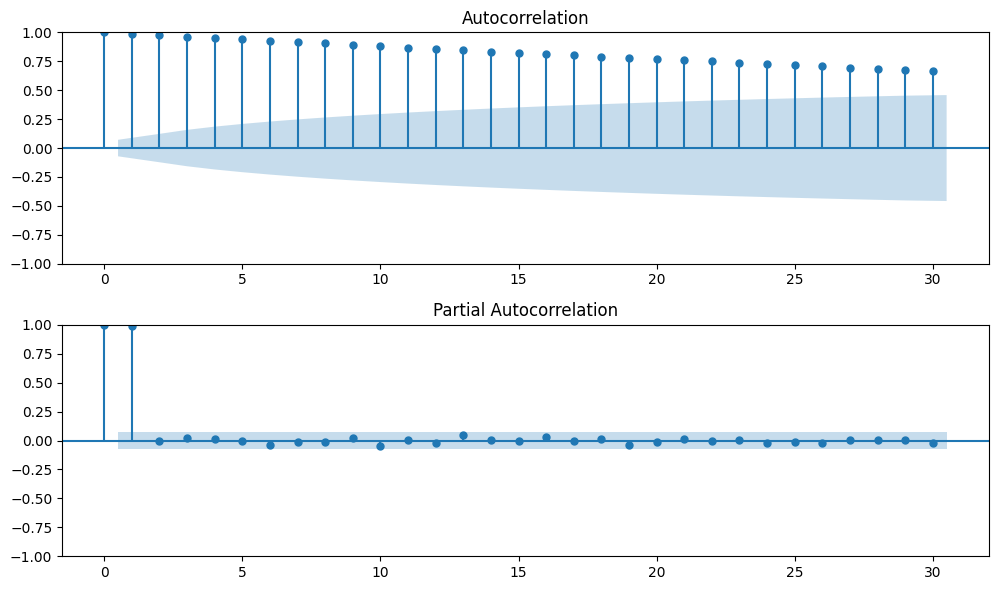

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plot_acf(df['Close'], lags=30, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(df['Close'], lags=30, ax=plt.gca())
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Checking Stationarity
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.6252496584516998
p-value: 0.469978194254288
Critical Values: {'1%': -3.439075747702915, '5%': -2.8653910653234655, '10%': -2.568820711931304}


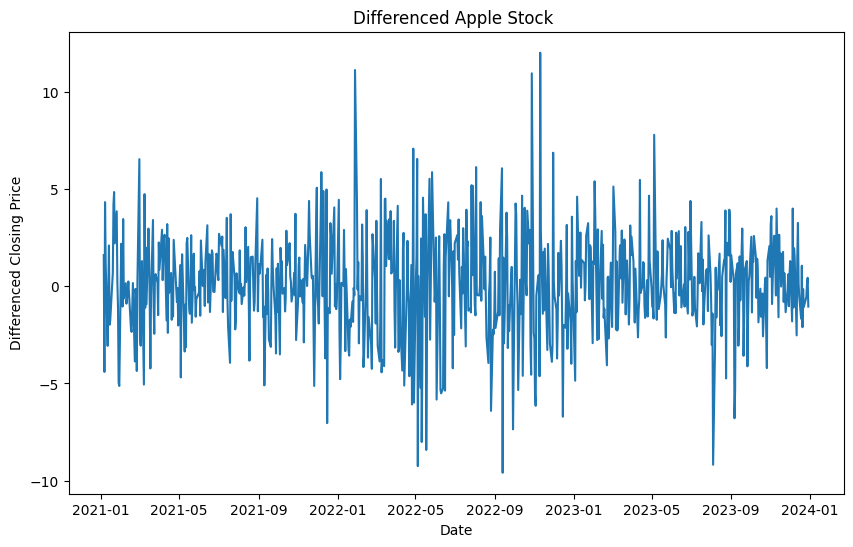

In [ ]:
# Differencing to make the time series stationary
df['Close_diff'] = df['Close'] - df['Close'].shift(1)
df['Close_diff'].dropna(how='any', inplace=True)

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df['Close_diff'])
plt.xlabel('Date')
plt.ylabel('Differenced Closing Price')
plt.title('Differenced Apple Stock ')
plt.show()

In [ ]:
cdiff = df['Close_diff'].drop(df.index[0])

In [ ]:
# Checking Stationarity again

# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(cdiff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -20.44107308468627
p-value: 0.0
Critical Values: {'1%': -3.439099096730074, '5%': -2.8654013553540745, '10%': -2.568826193777778}


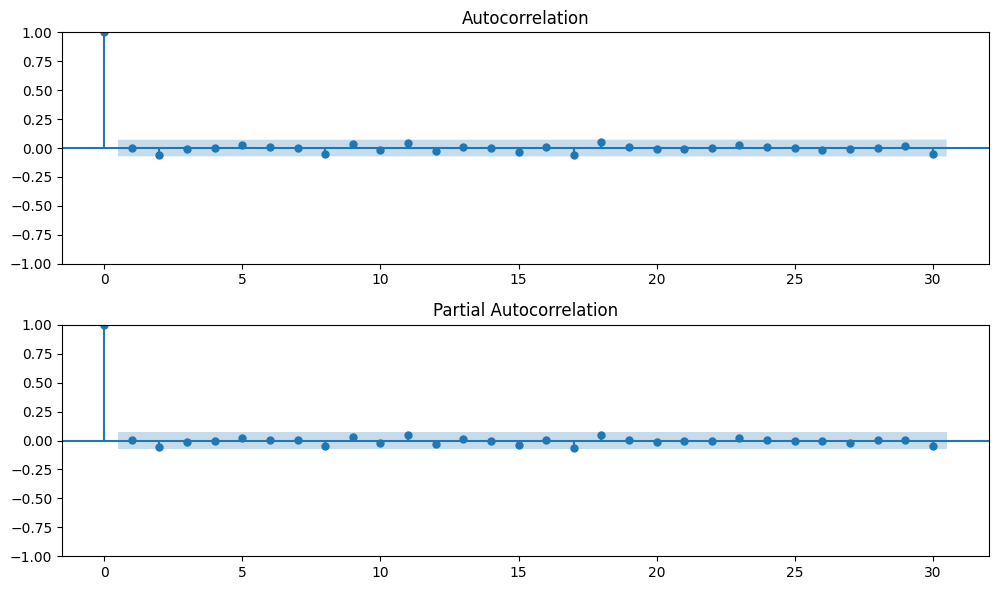

In [ ]:
#Plotting ACF and PACF for differenced data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plot_acf(cdiff, lags=30, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(cdiff, lags=30, ax=plt.gca())
plt.tight_layout()
plt.show()

In [ ]:
# 1
date_range = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
cdiff = pd.DataFrame({'Close': cdiff}, index=date_range)

In [ ]:
print(pd.isnull(cdiff))

            Close
2021-01-01   True
2021-01-02   True
2021-01-03   True
2021-01-04   True
2021-01-05  False
...           ...
2023-12-27  False
2023-12-28  False
2023-12-29  False
2023-12-30   True
2023-12-31   True

[1095 rows x 1 columns]


In [ ]:
cdiff_new = cdiff.dropna()

In [ ]:
print(pd.isnull(cdiff_new))

            Close
2021-01-05  False
2021-01-06  False
2021-01-07  False
2021-01-08  False
2021-01-11  False
...           ...
2023-12-22  False
2023-12-26  False
2023-12-27  False
2023-12-28  False
2023-12-29  False

[752 rows x 1 columns]


In [ ]:
#!pip install pmdarima

In [ ]:
# Trying to find appropriate model
import pmdarima
from pmdarima import auto_arima

stepwise_model = auto_arima(cdiff_new, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=True, stationary=False,
                           d=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4123.746, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3938.918, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4121.747, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3937.551, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3938.926, Time=0.87 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3940.062, Time=2.11 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3840.163, Time=0.19 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3841.614, Time=0.72 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=3841.627, Time=0.62 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3842.818, Time=2.02 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=3786.808, Time=0.24 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=3788.614, Time=0.71 sec
 ARIMA(3,1,0)(0,0,1)[12] inte

In [ ]:
# Train test split
train = cdiff_new.loc['2021-01-01':'2023-11-30']
test = cdiff_new.loc['2023-12-01':]

In [ ]:
# Train the model
stepwise_model.fit(train)

ARIMA(order=(10, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



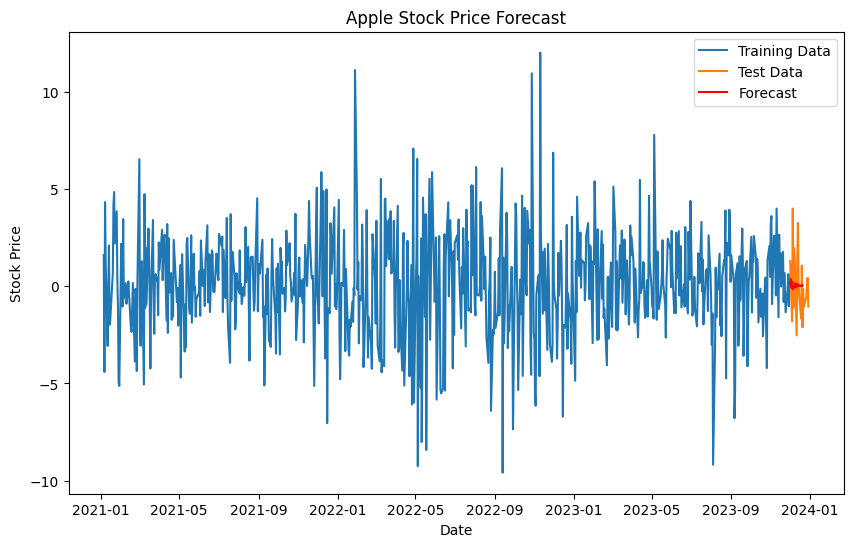

Forecasted Apple Stock Prices:
          Date  Predicted_Close
732 2023-12-01         0.140654
733 2023-12-02         0.362852
734 2023-12-03        -0.064922
735 2023-12-04         0.232212
736 2023-12-05        -0.161940
737 2023-12-06        -0.001748
738 2023-12-07        -0.033559
739 2023-12-08        -0.063271
740 2023-12-09         0.144573
741 2023-12-10        -0.073992
742 2023-12-11         0.133572
743 2023-12-12         0.040198
744 2023-12-13         0.076926
745 2023-12-14         0.004539
746 2023-12-15         0.039151
747 2023-12-16         0.008079
748 2023-12-17         0.013712
749 2023-12-18         0.040055
750 2023-12-19         0.015168
751 2023-12-20         0.053227


In [ ]:
# Forecasting
future_forecast = stepwise_model.predict(n_periods=len(test))

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=test.index[0], periods=len(test))
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_Close': future_forecast
})

# Visualize the forecasted values along with the actual test data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, label='Training Data')
plt.plot(test.index, test.values, label='Test Data')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Close'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Price Forecast')
plt.legend()
plt.show()

# Print the forecasted values
print("Forecasted Apple Stock Prices:")
print(forecast_df)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, future_forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, future_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 1.429126252700018
Mean Squared Error (MSE): 3.0512186553899143
Root Mean Squared Error (RMSE): 1.746773784835894


In [ ]:
# Prompt the user to enter a date
input_date_str = input("Enter a date in 'YYYY-MM-DD' format: ")

# Parse the input date
input_date = pd.to_datetime(input_date_str)

# Check if the entered date is within the range of available dates
if input_date < forecast_df['Date'].min() or input_date > forecast_df['Date'].max():
    print("Entered date is outside the range of available dates.")
else:
    try:
        # Get the index of the entered date in the forecast DataFrame
        idx = forecast_df.index[forecast_df['Date'] == input_date][0]

        # Get the predicted difference for the entered date
        predicted_difference = forecast_df.loc[idx, 'Predicted_Close']

        # Get the last known actual closing price
        last_known_close = df.loc[df.index[-1], 'Close']

        # Calculate the predicted closing price
        predicted_close = last_known_close + predicted_difference

        try:
            # Get the actual closing price for the entered date
            actual_close = df.loc[input_date, 'Close']

            # Print the predicted and actual closing prices
            print(f"Predicted closing price for {input_date_str}: {predicted_close}")
            print(f"Actual closing price for {input_date_str}: {actual_close}")

        except KeyError:
            print(f"No data available for the entered date {input_date_str}.")

    except IndexError:
        print(f"No data available for the entered date {input_date_str}.")


Enter a date in 'YYYY-MM-DD' format: 2023-12-07
Predicted closing price for 2023-12-07: 192.49643971502186
Actual closing price for 2023-12-07: 194.27000427246094
